In [1640]:
# import libraries
import pandas as pd
import seaborn as sns
from openpyxl import Workbook
from openpyxl.styles import Font
import numpy as np
import time
import matplotlib.pyplot as plt #only used to adjust axis

# download the following imported modules:

import xlsxwriter
from fuzzywuzzy import process # import the fuzzywuzzy module for correcting typos
import pint



In [1641]:
# time the code
start_time = time.time()


# open file
file = 'amazon_laptop_2023.xlsx'
df = pd.read_excel(file)


In [1642]:
# Drops rows when the 'price' column is empty


# Calculate the percentage of missing values in each column
missing_percentages = (df.isnull().sum() / len(df)) * 100


In [1643]:
# Create a DataFrame, then display the missing percentage for each column
missing_percentage_df = pd.DataFrame({
    'Column': missing_percentages.index,
    'Missing Percentage': missing_percentages.values
})

# Display the table of missing percentages
print("% of missing values in each column:")
print(missing_percentage_df)

% of missing values in each column:
                  Column  Missing Percentage
0                  brand            0.000000
1                  model           26.180837
2            screen_size            0.652272
3                  color           13.022942
4               harddisk           12.955466
5                    cpu            2.249213
6                    ram            1.372020
7                     OS            0.584795
8       special_features           53.801170
9               graphics            1.461988
10  graphics_coprocessor           42.105263
11             cpu_speed           65.811966
12                rating           51.102114
13                 price            0.112461


In [1644]:
# dropped the graphics coprocessor column because it is more than 50% empty
# not much use for it
# df.drop(['graphics_coprocessor'], axis=1, inplace=True)

In [1645]:
# drop rows when price unknown
df = df.dropna(subset=['price'])

In [1646]:
# print unique brand names, for analysis

unique_brand_values = df['brand'].unique()
print(unique_brand_values)
# now, i have all important brand names so i can correct the wrong ones via fuzzywuzzy
all_brands = 'HP', 'Dell', 'MSI', 'Lenovo', 'Acer', 'ASUS', 'LG', 'Apple', 'Microsoft', 'SAMSUNG', 'Gigabyte', 'Alienware', 'Razer', 'Corsair', 'XPG', 'Panasonic', 'LPT', 'VAIO'

['HP' 'Dell' 'MSI' 'Lenovo' 'acer' 'Acer' 'ASUS' 'LG' 'Apple' 'Microsoft'
 'SAMSUNG' 'Gigabyte' 'Toughbook' 'Alienware' 'XAMMUE' 'LENOVO' 'DELL'
 'dell' 'lenovo' 'SHOXLAB' 'Razer' 'asus' 'Corsair' 'XPG' 'Panasonic'
 'LPT' 'VAIO' 'hp' 'Latitude' 'Carlisle FoodService Products' 'Gateway'
 'Quality Refurbished Computers' 'TOPOSH' 'IVIEW' 'MAINGEAR'
 'Computer Upgrade King' 'Elo' 'GizPro' 'JTD' 'Mytrix' 'ONN' 'Goldengulf'
 'Luqeeg' 'Tocosy' 'ROKC' 'Asus' 'AWOW' 'Best Notebooks' 'CTL' 'Mac'
 'MICROTELLA' 'enovo']


In [1647]:
# corrects typos, using fuzzywuzzy 
# also, when the brand == 'mac', it converts it to 'apple'
def correct_typos(input_string, options):
    if input_string.lower() == 'mac':
        return 'Apple'
    
    match, score = process.extractOne(input_string, options)
    if score >= 75:
        return match
    else:
        return input_string

df['brand'] = df['brand'].apply(lambda x: correct_typos(x, all_brands))

# [1] code based off of discussion in stack exchange:
# https://codereview.stackexchange.com/questions/215174/find-a-best-fuzzy-match-for-a-string
# [2] also based off kaggle form:
# https://www.kaggle.com/code/prateekmaj21/fuzzywuzzy-python-library

In [1648]:
# check if there's duplicate rows
df_no_duplicates = df.drop_duplicates()
print("Shape before removing duplicates:", df.shape)
print("Shape after removing duplicates:", df_no_duplicates.shape)

# there are over 1800 duplicates!!!! remove them all:
df = df.drop_duplicates()

Shape before removing duplicates: (4441, 14)
Shape after removing duplicates: (2623, 14)


In [1649]:
# Convert price from strings to floats
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

# Get rid of units for screen_size and change data into floats
df['screen_size'] = df['screen_size'].replace('Inches$', '', regex=True).astype(float)

# remove any data that ends in MB for RAM, because it is an outlier and must be incorrect data
# then get rid of the GB part and convert to a float.
df = df[~df['ram'].astype(str).str.endswith('MB')]
df['ram'] = df['ram'].replace('GB$', '', regex=True).astype(float)

# [3] change data type code based off of:
# https://saturncloud.io/blog/how-to-convert-a-column-in-pandas-dataframe-from-string-to-float/#:~:text=10.11%204%2012.34-,To%20convert%20a%20column%20in%20a%20pandas%20DataFrame%20from%20a,object%20to%20a%20specified%20dtype.

In [1650]:
# change the column names, includes units now
newColumnNames = ['brand', 'model', 'screen_size(inches)', 'colour', 'harddisk(GB)', 'CPU', 'RAM(GB)', 'OS', 'special_features', 'graphics', 'graphics_coprocessor', 'cpu_speed(GHz)', 'rating', 'price($)']

df.columns = newColumnNames
print(df.columns)

Index(['brand', 'model', 'screen_size(inches)', 'colour', 'harddisk(GB)',
       'CPU', 'RAM(GB)', 'OS', 'special_features', 'graphics',
       'graphics_coprocessor', 'cpu_speed(GHz)', 'rating', 'price($)'],
      dtype='object')


In [1651]:
# remove row if the model is unknown, because the user can't order the laptop otherwise
df = df.dropna(subset=['model'])

In [1652]:
# convert harddisk data from strings into floats, to make the data easier to deal with
def str_to_float_harddisk(value):
    try:
        if isinstance(value, (int, float)):
            return float(value) 
        elif 'TB' in value:   #TB to GB
            return float(value.replace('TB', '')) * 1000 
        elif 'GB' in value:
            return float(value.replace('GB', ''))
        else: #if data isn't already a float/GB/TB, then anomaly
            return 0
    except ValueError: #if above code can't run, just remove the data
        return 0


df['harddisk(GB)'] = df['harddisk(GB)'].apply(str_to_float_harddisk)

# [4] isinstance() info from: 
# https://www.programiz.com/python-programming/methods/built-in/isinstance

In [1653]:
# further clean the harddisk column, removing outliers
min_harddisk_value = df['harddisk(GB)'].min()
print("min harddisk storage:", min_harddisk_value)
max_harddisk_value = df['harddisk(GB)'].max()
print("max harddisk storage:", max_harddisk_value)
# 8 TB is realistic, but anything less than about 50GB isn't realistic, so probably an anomaly
df = df[df['harddisk(GB)'] >= 50]

min_harddisk_value = df['harddisk(GB)'].min()
print(min_harddisk_value)

min harddisk storage: 0.0
max harddisk storage: 8000.0
64.0


In [1654]:
max_rating = df['rating'].max()
min_rating = df['rating'].min()
print("max rating:", max_rating)
print("min rating:", min_rating)
# no outliers in rating column, no need to further clean rating column

max rating: 5.0
min rating: 1.0


In [1655]:
# convert spu_speed data from strings into floats, to make the data easier to deal with
def cpu_speed_clean(value):
    try:
        if isinstance(value, (int, float)):
            return float(value) 
        elif 'MHz' in value:   #MHz to GHz
            return float(value.replace('MHz', '')) / 1000 
        elif 'GHz' in value:
            return float(value.replace('GHz', ''))
        else: #if data isn't already a float/GHz/MHz, then anomaly
            return 0
    except ValueError: #if above code can't run, just remove the data
        return 0


df['cpu_speed(GHz)'] = df['cpu_speed(GHz)'].apply(cpu_speed_clean)

In [1656]:
# first make colour column all lowercase
df['colour'] = df['colour'].str.lower()
# now correct spelling, (from analysis using print(), grey is spelt gary and gray sometimes)
colours = 'grey'
df['colour'] = df['colour'].astype(str)

df['colour'] = df['colour'].replace('gray', colours)
df['colour'] = df['colour'].replace('gary', colours)

unique_colours = df['colour'].unique()
print(unique_colours)
# but, from printing this, i can see that it only partially worked. still more work to do.

['silver' 'black' 'grey, gray, platinum silver' 'grey' 'nan'
 'gray, platinum silver' 'carbon gray' 'titan gray' 'pure silver'
 'platinum silver' 'eclipse gray' 'dark moss' 'natural silver'
 'graphite black' 'graphite' 'aluminum' 'arctic grey' 'platinum' 'blue'
 'green' 'slate grey' 'silver/carbon fiber' 'sky' 'shadow grey'
 'burgundy red' 'midnight' 'mecha gray' 'off black' 'mineral grey'
 'mist blue' 'punk pink' 'shale black' 'star black' 'carbon fiber'
 'gray, silver' 'shadow black' 'white' 'fog blue' 'rgb backlit'
 'cloud grey' 'phantom grey' 'dark side of the moon' 'basalt grey'
 'matte black' 'mystic blue' 'indie black' 'obsidian black' 'stormy grey'
 'mystic black' 'phantom grey with speckles' 'ink black' 'galaxy black'
 'evo i7-1260p' 'titan gray dull' 'aluminum titan gray' 'dark shadow grey'
 'royal blue' 'jade black' 'quiet blue' 'mica silver' 'phantom blue'
 'dark side of the moon with high endurance clear coat and silky smooth finish'
 'black paint' 'anodized titan gray' 'l

In [1657]:
# save the file
df.to_excel('cleaned_data.xlsx', index=False)

In [1658]:
# finish timing
finish_time = time.time()
print(finish_time - start_time)

5.378614187240601


In [1659]:
############ QUESTION 2 ################
# --------------------------------------
# --------------------------------------
#---------------------------------------

In [1660]:
df.describe()
# the following numerical data suggests data is well cleaned, there are no outliers

,screen_size(inches),harddisk(GB),RAM(GB),cpu_speed(GHz),rating,price($)
count,2289.000000,2289.000000,2242.000000,198.000000,817.000000,2289.000000
mean,15.079445,903.111839,22.774304,2.765556,4.090208,1433.557436
std,1.290826,1016.082328,16.892521,1.150157,0.822003,886.987374
min,10.100000,64.000000,1.000000,0.900000,1.000000,84.540000
25%,14.000000,256.000000,12.000000,1.825000,3.800000,799.990000
50%,15.600000,512.000000,16.000000,2.600000,4.200000,1239.770000
75%,15.600000,1000.000000,32.000000,3.467500,4.600000,1865.990000
max,18.000000,8000.000000,128.000000,5.600000,5.000000,11261.240000


In [1661]:
# normalise the following columns
columns_for_normalisation = ['price($)', 'RAM(GB)', 'harddisk(GB)', 'rating','cpu_speed(GHz)', 'screen_size(inches)']
# use normal_dict to store data to work out z score
normal_dict = {}

In [1662]:
# RECCOMENDATIONS FOR STUDENT
# criteria for students
max_budget = 1500  
min_rating = 3   
min_harddisk = 200
min_ram = 8

# remove data that doesn't meet criteria
# df2 = filtered laptops, with minimum data required
df2 = df[
    (df['price($)'] <= max_budget) &
    ((df['rating'] >= min_rating) | df['rating'].isna()) &  # use rating>=3 or unrated
    (df['harddisk(GB)'] >= min_harddisk) &
    (df['RAM(GB)'] >= min_ram)
].copy()

for i in columns_for_normalisation:
    normal_dict[i] = {
        'mean': df2[i].mean(),
        'std': df2[i].std()
    }
print(normal_dict)


{'price($)': {'mean': 945.1047731239042, 'std': 303.3578132982154}, 'RAM(GB)': {'mean': 19.078534031413614, 'std': 13.338028239775142}, 'harddisk(GB)': {'mean': 722.1186736474694, 'std': 623.0017711571683}, 'rating': {'mean': 4.266666666666665, 'std': 0.5433188244216333}, 'cpu_speed(GHz)': {'mean': 2.5581395348837215, 'std': 1.0332661084586063}, 'screen_size(inches)': {'mean': 14.806588132635293, 'std': 1.1161547996435541}}


In [1663]:
# remove all rows when OS is unknown, or when OS is an older version of windows
# i did this by removing all rows that have an epty OS column, or don't have the 
# following substrings: ["windows 10", "windows 11", "mac os", "macos", "windows10", "windows11"]

df2['OS'] = df2['OS'].str.lower() #first make everything lower
df2 = df2.dropna(subset=['OS']) #drop row when OS empty

os_substrings = ["windows 10", "windows 11", "mac os", "macos", "chrome os", "win 10", "win 11"] # valid OS systems
# df2 = df2[df2['OS'].str.lower().str.contains('|'.join(os_substrings))] # remove when != valid OS

# remove unnnessesary information
# so, only show if its windows10/11 or mac
df2['OS'] = np.where(df2['OS'].str.contains('windows 10|win 10', case=False), 'windows 10', df2['OS'])
df2['OS'] = np.where(df2['OS'].str.contains('windows 11|win 11', case=False), 'windows 11', df2['OS'])
#now, make both 'mac os' and 'macos' equal to 'mac os'
df2['OS'] = np.where(df2['OS'].str.contains('mac', case=False), 'mac os', df2['OS'])

# now print all unique OS systems left
unique_os = df2['OS'].unique()
print(unique_os)


# [5] Replace column values based on conditions in Pandas, used code inspired from:
# https://thispointer.com/replace-column-values-based-on-conditions-in-pandas/

['windows 10' 'windows 11' 'mac os' 'chrome os' 'windows 7'
 'windows 7 professional' 'windows 8' 'windows 8.1' 'windows'
 'windows 7 pro + 10 pro']


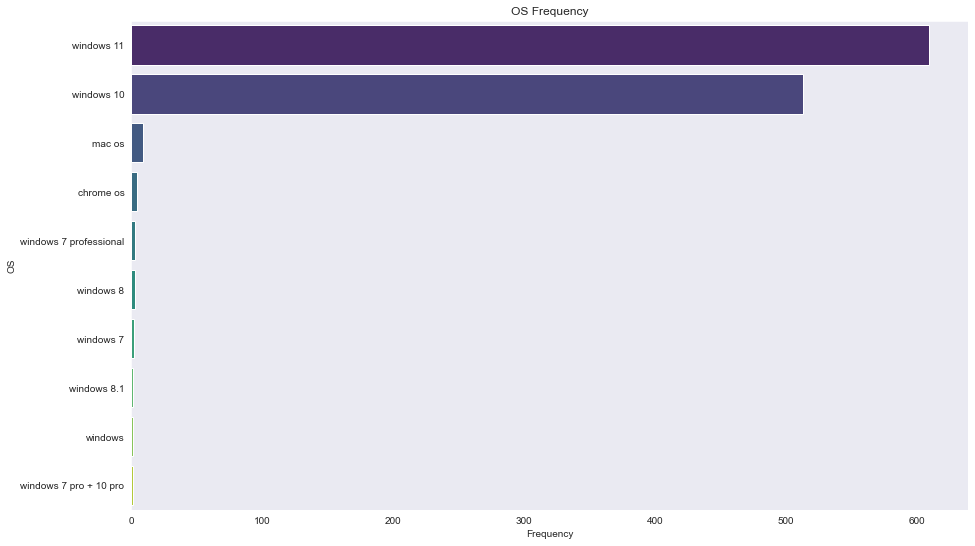

In [1664]:
# create seaborn chart
os_counts = df2['OS'].value_counts().reset_index()
os_counts.columns = ['OS', 'Count']

plt.figure(figsize=(15, 9))
sns.barplot(x='Count', y='OS', data=os_counts, palette="viridis")
plt.title('OS Frequency')
plt.xlabel('Frequency')
plt.ylabel('OS')
plt.show()

df2 = df2[df2['OS'].str.lower().str.contains('|'.join(os_substrings))] # remove when != valid OS

In [1665]:

# calculate z score of RAM, price and harddisk
#  formula for z-score:     z = (x - mean) / std
df2['normalized_RAM'] = (df2['RAM(GB)'] - normal_dict['RAM(GB)']['mean']) / normal_dict['RAM(GB)']['std']
df2['normalized_harddisk'] = (df2['harddisk(GB)'] - normal_dict['harddisk(GB)']['mean']) / normal_dict['harddisk(GB)']['std']
df2['normalized_price'] = (df2['price($)'] - normal_dict['price($)']['mean']) / normal_dict['price($)']['std']

# ranking calculated using weights 
# weight for price is negative because you want low price
weights = {'normalized_RAM': 0.2, 'normalized_harddisk': 0.2, 'normalized_price': -0.8}
df2['ranking_score'] = (
    df2['normalized_RAM'] * weights['normalized_RAM'] +
    df2['normalized_harddisk'] * weights['normalized_harddisk'] +
    df2['normalized_price'] * weights['normalized_price']
)

# Recommending top 5 laptops based on ranking_score
recommended_laptops = df2.nlargest(5, 'ranking_score')

# Display the recommended laptops
print(recommended_laptops[['brand', 'model', 'price($)', 'RAM(GB)', 'harddisk(GB)', 'rating', 'ranking_score']])
print(recommended_laptops[['brand', 'model', 'price($)']])

# [6] calculate z score:
# https://www.simplypsychology.org/z-score.html#:~:text=The%20formula%20for%20calculating%20a,Figure%202.

       brand             model  price($)  RAM(GB)  harddisk(GB)  rating  \
1999      HP            Laptop    298.70     32.0        2000.0     NaN   
1444  Lenovo              T450    139.98     16.0         256.0     5.0   
1441  Lenovo   Lenovo Thinkpad    138.00      8.0         320.0     3.9   
2176    Dell     Dell Inspiron    356.99      8.0        2000.0     3.5   
1453      HP  Elitebook 840 G3    159.99      8.0         256.0     4.0   

      ranking_score  
1999       2.308654  
1444       1.927436  
1441       1.833246  
2176       1.795061  
1453       1.754709  
       brand             model  price($)
1999      HP            Laptop    298.70
1444  Lenovo              T450    139.98
1441  Lenovo   Lenovo Thinkpad    138.00
2176    Dell     Dell Inspiron    356.99
1453      HP  Elitebook 840 G3    159.99


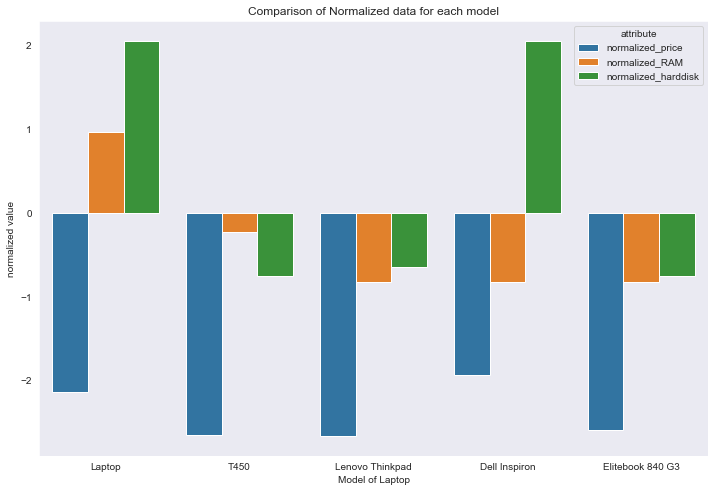

In [1666]:
# Reshape the DataFrame to have 'attribute' and 'value' columns
new_df = recommended_laptops.melt(id_vars='model', value_vars=['normalized_price', 'normalized_RAM', 'normalized_harddisk'], var_name='attribute', value_name='value')

# Create a grouped bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='model', y='value', hue='attribute', data=new_df)
plt.title('Comparison of Normalized data for each model')
plt.xlabel('Model of Laptop')
plt.ylabel('normalized value')
plt.show()


In [1667]:
# RECCOMENDATIONS FOR GAMER
# this code will be pretty much same as for student, so less comments used

# criteria for gamer
max_budget = 1500  
min_rating = 3   
min_harddisk = 450
min_ram = 8
min_cpu_speed = 3
min_screen_size = 14

# remove data that doesn't meet criteria
# df3 = filtered laptops, with minimum data required
df3 = df[
    (df['price($)'] <= max_budget) &
    ((df['rating'] >= min_rating) | df['rating'].isna()) & 
    (df['harddisk(GB)'] >= min_harddisk) &
    (df['RAM(GB)'] >= min_ram) &
    (df['cpu_speed(GHz)'] >= min_cpu_speed) &
    (df['screen_size(inches)'] >= min_screen_size)
].copy()

for i in columns_for_normalisation:
    normal_dict[i] = {
        'mean': df3[i].mean(),
        'std': df3[i].std()
    }
print(normal_dict)


{'price($)': {'mean': 1053.2517647058826, 'std': 326.9787132069016}, 'RAM(GB)': {'mean': 15.529411764705882, 'std': 7.194769341845014}, 'harddisk(GB)': {'mean': 628.2352941176471, 'std': 372.7102643830334}, 'rating': {'mean': 4.3875, 'std': 0.5743008171432707}, 'cpu_speed(GHz)': {'mean': 3.994117647058823, 'std': 0.7039802804724843}, 'screen_size(inches)': {'mean': 15.21176470588235, 'std': 0.91506991054043}}


In [1668]:
df3['OS'] = df3['OS'].str.lower()
df3 = df3.dropna(subset=['OS'])

os_substrings = ["windows 10", "windows 11", "mac os", "macos", "chrome os", "win 10", "win 11"] 
df3 = df3[df3['OS'].str.lower().str.contains('|'.join(os_substrings))] 

df3['OS'] = np.where(df3['OS'].str.contains('windows 10|win 10', case=False), 'windows 10', df3['OS'])
df3['OS'] = np.where(df3['OS'].str.contains('windows 11|win 11', case=False), 'windows 11', df3['OS'])

df3['OS'] = np.where(df3['OS'].str.contains('mac', case=False), 'mac os', df3['OS'])

unique_os = df3['OS'].unique()

In [1669]:
df3['normalized_RAM'] = (df3['RAM(GB)'] - normal_dict['RAM(GB)']['mean']) / normal_dict['RAM(GB)']['std']
df3['normalized_harddisk'] = (df3['harddisk(GB)'] - normal_dict['harddisk(GB)']['mean']) / normal_dict['harddisk(GB)']['std']
df3['normalized_price'] = (df3['price($)'] - normal_dict['price($)']['mean']) / normal_dict['price($)']['std']
df3['normalized_cpu'] = (df3['cpu_speed(GHz)'] - normal_dict['cpu_speed(GHz)']['mean']) / normal_dict['cpu_speed(GHz)']['std']
df3['normalized_screen'] = (df3['screen_size(inches)'] - normal_dict['screen_size(inches)']['mean']) / normal_dict['screen_size(inches)']['std']


weights = {'normalized_RAM': 0.4, 'normalized_harddisk': 0.4, 'normalized_price': -0.3, 'normalized_cpu':0.3, 'normalized_screen':0.2}
df3['ranking_score'] = (
    df3['normalized_RAM'] * weights['normalized_RAM'] +
    df3['normalized_harddisk'] * weights['normalized_harddisk'] +
    df3['normalized_price'] * weights['normalized_price'] +
    df3['normalized_cpu'] * weights['normalized_cpu'] +
    df3['normalized_screen'] * weights['normalized_screen']
)

recommended_laptops = df3.nlargest(5, 'ranking_score')

print(recommended_laptops[['brand', 'model', 'price($)', 'RAM(GB)', 'harddisk(GB)','cpu_speed(GHz)','screen_size(inches)', 'rating', 'ranking_score']])
print(recommended_laptops[['brand', 'model', 'price($)']])

     brand            model  price($)  RAM(GB)  harddisk(GB)  cpu_speed(GHz)  \
2176  Dell    Dell Inspiron    356.99      8.0        2000.0             3.4   
4174  Dell    Latitude 5440    997.74     32.0         512.0             5.0   
540   Dell    Latitude 5530   1488.95     32.0         512.0             4.7   
368     LG  16Z90Q-N.APB7U1   1299.99     16.0        1000.0             4.7   
2855  Acer     AV14-51-58XZ    532.49     16.0         512.0             4.4   

      screen_size(inches)  rating  ranking_score  
2176                 15.6     3.5       1.524085  
4174                 14.0     NaN       1.005692  
540                  15.6     NaN       0.776867  
368                  16.0     NaN       0.671857  
2855                 14.0     4.8       0.287331  
     brand            model  price($)
2176  Dell    Dell Inspiron    356.99
4174  Dell    Latitude 5440    997.74
540   Dell    Latitude 5530   1488.95
368     LG  16Z90Q-N.APB7U1   1299.99
2855  Acer     AV14-51-

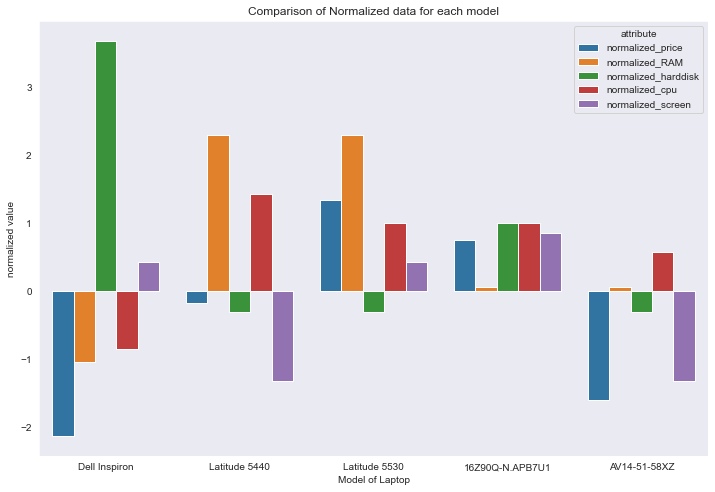

In [1670]:
# Reshape the DataFrame to have 'attribute' and 'value' columns
new_df = recommended_laptops.melt(id_vars='model', value_vars=['normalized_price', 'normalized_RAM', 'normalized_harddisk', 'normalized_cpu', 'normalized_screen'], var_name='attribute', value_name='value')

# Create a grouped bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='model', y='value', hue='attribute', data=new_df)
plt.title('Comparison of Normalized data for each model')
plt.xlabel('Model of Laptop')
plt.ylabel('normalized value')
plt.show()

In [1671]:
# finish timing
finish_time = time.time()
print(finish_time - start_time)

5.994721174240112


In [1672]:
df3.describe()

,screen_size(inches),harddisk(GB),RAM(GB),cpu_speed(GHz),rating,price($),normalized_RAM,normalized_harddisk,normalized_price,normalized_cpu,normalized_screen,ranking_score
count,17.000000,17.000000,17.000000,17.000000,8.000000,17.000000,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01
mean,15.211765,628.235294,15.529412,3.994118,4.387500,1053.251765,-7.020528e-17,-5.224579e-17,-6.236841e-16,6.726645e-16,2.644943e-15,9.208320e-16
std,0.915070,372.710264,7.194769,0.703980,0.574301,326.978713,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.393993e-01
min,14.000000,512.000000,8.000000,3.000000,3.500000,356.990000,-1.046512e+00,-3.118650e-01,-2.129379e+00,-1.412138e+00,-1.324232e+00,-1.267281e+00
25%,14.000000,512.000000,8.000000,3.300000,4.125000,997.740000,-1.046512e+00,-3.118650e-01,-1.697718e-01,-9.859902e-01,-1.324232e+00,-5.627635e-01
50%,15.600000,512.000000,16.000000,4.300000,4.550000,1099.000000,6.540699e-02,-3.118650e-01,1.399120e-01,4.345041e-01,4.242685e-01,3.319761e-02
75%,15.600000,512.000000,16.000000,4.500000,4.800000,1299.950000,6.540699e-02,-3.118650e-01,7.544780e-01,7.186030e-01,4.242685e-01,2.873307e-01
max,17.000000,2000.000000,32.000000,5.000000,5.000000,1488.950000,2.289245e+00,3.680512e+00,1.332497e+00,1.428850e+00,1.954206e+00,1.524085e+00
